In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import statsmodels.api as sm

In [2]:
resample = pd.read_csv('reample_csv')
print(resample.shape[0])

suc_data = pd.read_csv('suc_df_1768.csv')
print(suc_data.shape[0])

force_data = pd.read_csv('force_resampling.csv')
print(force_data.shape[0])

1768
1768
1768


In [11]:
total_df = pd.read_csv('feature_selection.csv')
total_df

,mem_no,mem_birth_year,mem_birth_month,photo_cnt,mate_height,mate_weight,mate_offspring_m,mate_offspring_f,divorce_year,upd_cnt,conts_upd_cnt,family_conts_upd_cnt,my_point_cont,suc_yn
0,1572407,1998,7,0,166,51,0,0,0,1,0,0,46,0
1,1542770,1998,9,2,160,60,0,0,0,1,0,0,50,0
2,1749993,1997,1,0,160,53,0,0,0,2,0,0,53,0
3,1795208,2003,1,0,151,76,0,0,0,1,0,0,40,0
4,1815315,2003,1,0,167,53,0,0,0,1,0,0,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5299,1526578,1951,12,0,171,65,0,0,2011,27,8,1,95,-1
5300,1058558,1952,8,13,164,80,0,0,0,7,3,0,75,-1
5301,1792026,1950,7,4,167,65,1,2,2016,1,0,0,90,-1
5302,1736223,1952,1,3,165,63,1,0,2018,1,0,0,70,-1


In [12]:
df = total_df[['mem_no', 'mem_birth_year','mem_birth_month', 'photo_cnt',
       'mate_height', 'mate_weight', 'mate_offspring_m', 'mate_offspring_f',
       'divorce_year', 'upd_cnt', 'conts_upd_cnt',
       'family_conts_upd_cnt', 'my_point_cont','suc_yn']]

In [16]:
## 전진 선택법
variables = df.columns[:-1].tolist() ## 설명 변수 리스트
 
y = df['suc_yn'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\PC\

In [17]:
selected_variables

['mem_no',
 'divorce_year',
 'my_point_cont',
 'mem_birth_year',
 'photo_cnt',
 'mate_weight']

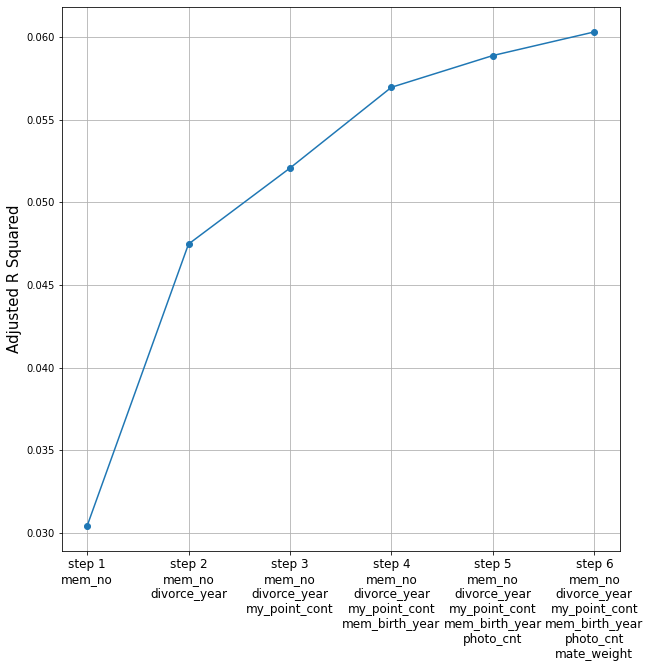

In [18]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

---

후진소거법

In [20]:
## 후진 소거법
variables = df.columns[:-1].tolist() ## 설명 변수 리스트
 
y = df['suc_yn'] ## 반응 변수
selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(df[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [21]:
selected_variables

['mem_no',
 'mem_birth_year',
 'photo_cnt',
 'mate_weight',
 'divorce_year',
 'my_point_cont']

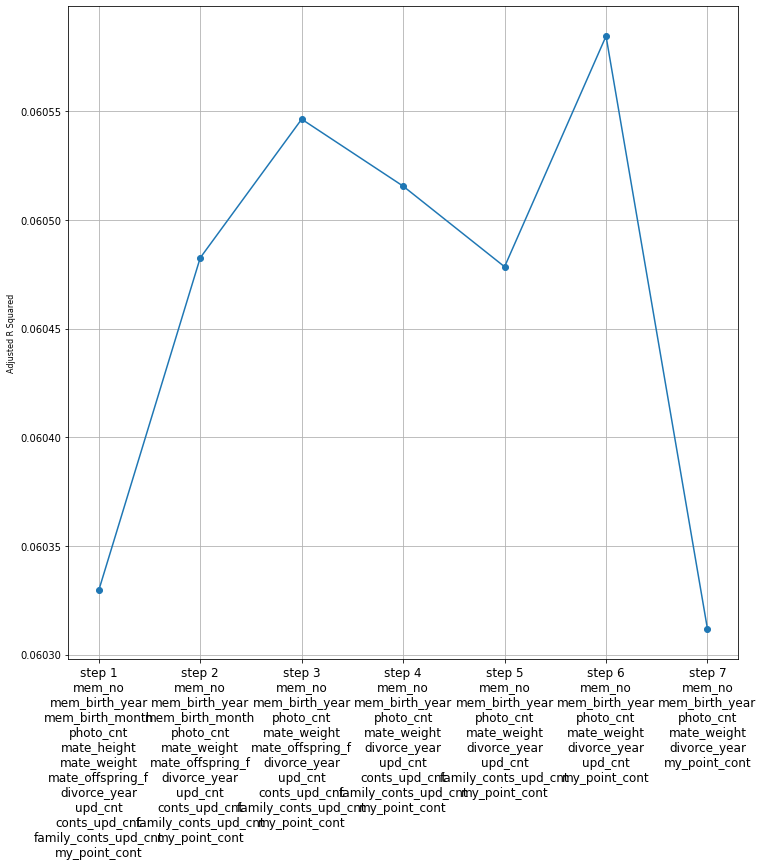

In [26]:
fig = plt.figure(figsize=(12,12))
fig.set_facecolor('white')
 
font_size = 8
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

---
단계별 선택법

In [27]:
## 전진 단계별 선택법
variables = df.columns[:-1].tolist() ## 설명 변수 리스트
 
y = df['suc_yn'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'obj

In [28]:
selected_variables

['mem_no',
 'divorce_year',
 'my_point_cont',
 'mem_birth_year',
 'photo_cnt',
 'mate_weight']

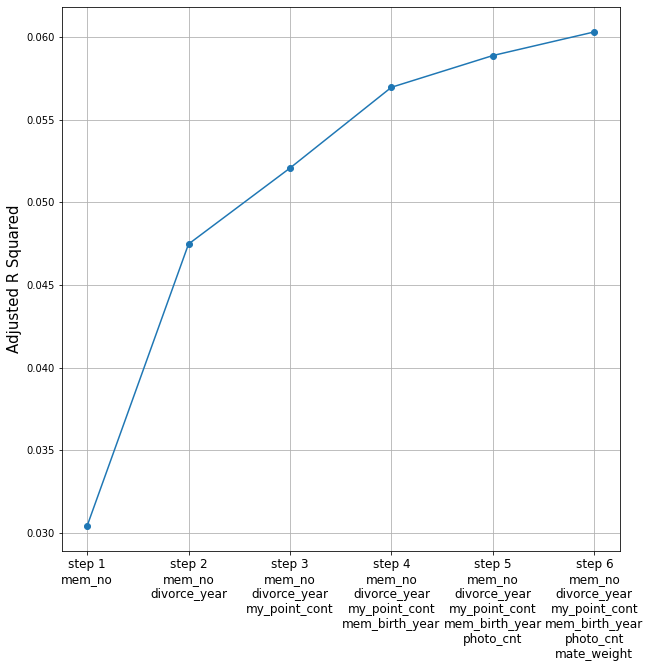

In [29]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()


----------
Normalization(데이터 정규화)

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df)
print(fitted.data_max_)
## 출력 결과
## [891.       1.       3.      80.       8.       6.     512.3292]
output = min_max_scaler.transform(df)
output = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))
print(output.head())

[1.821714e+06 2.003000e+03 1.200000e+01 5.000000e+01 1.970000e+02
 1.200000e+02 6.000000e+00 5.000000e+00 2.022000e+03 3.704500e+04
 1.574000e+03 1.510000e+02 1.000000e+02 1.000000e+00]
     mem_no  mem_birth_year  mem_birth_month  photo_cnt  mate_height  \
0  0.863048        0.909091         0.583333       0.00     0.340426   
1  0.846768        0.909091         0.750000       0.04     0.212766   
2  0.960602        0.890909         0.083333       0.00     0.212766   
3  0.985439        1.000000         0.083333       0.00     0.021277   
4  0.996485        1.000000         0.083333       0.00     0.361702   

   mate_weight  mate_offspring_m  mate_offspring_f  divorce_year   upd_cnt  \
0       0.1375               0.0               0.0           0.0  0.000027   
1       0.2500               0.0               0.0           0.0  0.000027   
2       0.1625               0.0               0.0           0.0  0.000054   
3       0.4500               0.0               0.0           0.0  0.0

In [34]:
## 전진 선택법
variables = df.columns[:-1].tolist() ## 설명 변수 리스트
 
y = output['suc_yn'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\PC\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\PC\

In [35]:
selected_variables

['mem_no',
 'divorce_year',
 'my_point_cont',
 'mem_birth_year',
 'photo_cnt',
 'mate_weight']

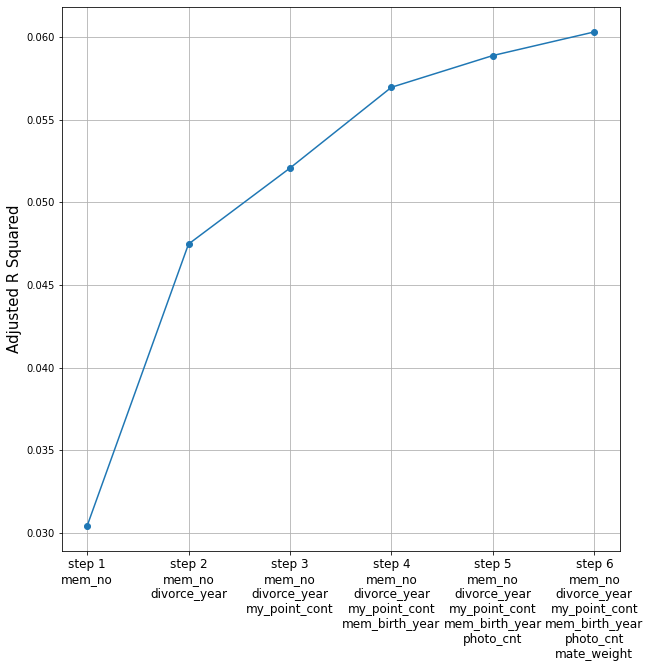

In [36]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [37]:
## 후진 소거법
variables = df.columns[:-1].tolist() ## 설명 변수 리스트
 
y = output['suc_yn'] ## 반응 변수
selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(df[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [38]:
selected_variables

['mem_no',
 'mem_birth_year',
 'photo_cnt',
 'mate_weight',
 'divorce_year',
 'my_point_cont']

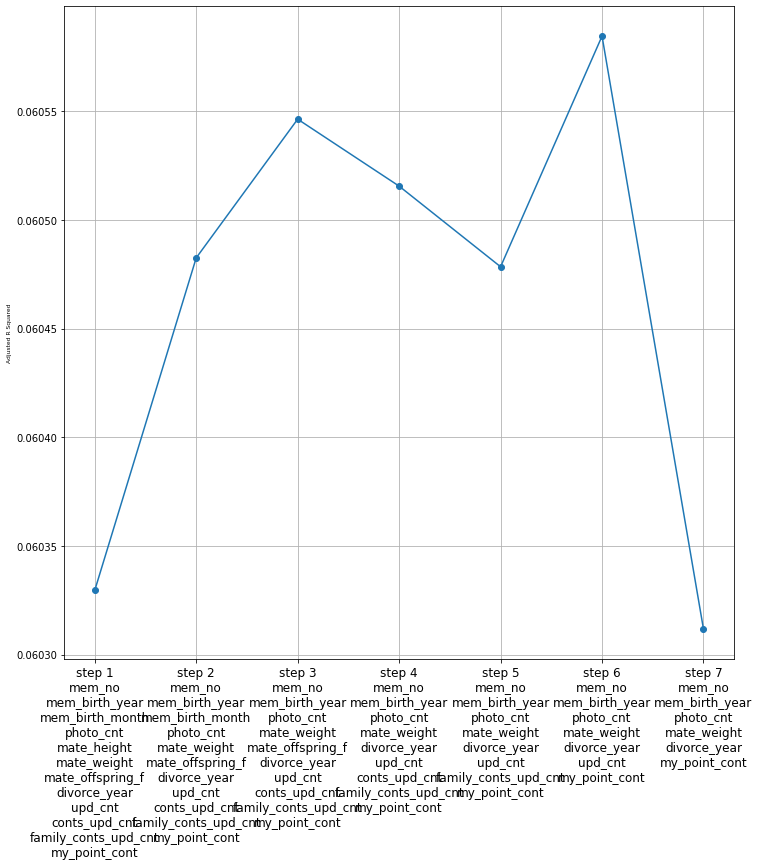

In [43]:
fig = plt.figure(figsize=(12,12))
fig.set_facecolor('white')
 
font_size = 6
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()
